In [ ]:
# pneumonia detection from chest x-rays using cnn and resnet50

# ------------------------------------------------------------------
# step 1: import libraries
# ------------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------------------------------------------------
# step 2: dataset paths
# ------------------------------------------------------------------
# set paths to train, test, and validation folders
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "val")

# ------------------------------------------------------------------
# step 3: data analysis
# ------------------------------------------------------------------
# print dataset stats
print("normal train:", len(os.listdir(os.path.join(train_path, 'NORMAL'))))
print("pneumonia train:", len(os.listdir(os.path.join(train_path, 'PNEUMONIA'))))
print("normal val:", len(os.listdir(os.path.join(val_path, 'NORMAL'))))
print("pneumonia val:", len(os.listdir(os.path.join(val_path, 'PNEUMONIA'))))

# ------------------------------------------------------------------
# step 4: preprocessing
# ------------------------------------------------------------------
img_size = (224, 224)
batch_size = 32

# use 20% of training data as validation set to improve accuracy
train_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# flow from the train_path for training data
train = train_gen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# flow from the train_path for validation data (using validation_split)
val = train_gen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1./255)
# flow from the test_path for testing data
test = test_gen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# ------------------------------------------------------------------
# step 5: compute class weights
# ------------------------------------------------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)
class_weights = dict(enumerate(class_weights))

# ------------------------------------------------------------------
# step 6: custom cnn model
# ------------------------------------------------------------------
# print('\ncustom cnn:')
# cnn_model = models.Sequential([
#     Input(shape=(224, 224, 3)),
#     layers.Conv2D(64, (7,7), activation='relu', padding='same'),
#     layers.MaxPooling2D(2),
#     layers.Conv2D(128, (3,3), activation='relu', padding='same'),
#     layers.Conv2D(128, (3,3), activation='relu', padding='same'),
#     layers.MaxPooling2D(2),
#     layers.Conv2D(256, (3,3), activation='relu', padding='same'),
#     layers.Conv2D(256, (3,3), activation='relu', padding='same'),
#     layers.MaxPooling2D(2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])

# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history1 = cnn_model.fit(train, validation_data=val, epochs=10, class_weight=class_weights)

print('\ncustom cnn:')

cnn_model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), padding='same'), # conv 1
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3, 3), padding='same'), # conv 2
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3, 3), padding='same'), # conv 3
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),

    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping + learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history1 = cnn_model.fit(train, validation_data=val, epochs=40, class_weight=class_weights, callbacks=[early_stop, lr_scheduler])

# ------------------------------------------------------------------
# step 7: transfer learning (resnet50)
# ------------------------------------------------------------------
print('\nresnet50:')
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# freeze some layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history2 = resnet_model.fit(train, validation_data=val, epochs=15, callbacks=[early_stop], class_weight=class_weights)#resnet_model.fit(train, validation_data=val, epochs=10, class_weight=class_weights)

# ------------------------------------------------------------------
# step 8: evaluation function
# ------------------------------------------------------------------
def evaluate_model(model, name):
    preds = model.predict(test)
    preds_labels = (preds > 0.5).astype("int32").flatten()
    true_labels = test.classes

    print(f"\n{name} Evaluation")
    print(classification_report(true_labels, preds_labels, target_names=["NORMAL", "PNEUMONIA"]))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, preds_labels))

# evaluate both models
evaluate_model(cnn_model, "Custom CNN")
evaluate_model(resnet_model, "ResNet50")



normal train: 1341
pneumonia train: 3875
normal val: 8
pneumonia val: 8
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

custom cnn:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 799ms/step - accuracy: 0.7715 - loss: 6.2791 - val_accuracy: 0.7430 - val_loss: 41.6739 - learning_rate: 0.0010
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 761ms/step - accuracy: 0.8394 - loss: 1.5158 - val_accuracy: 0.7430 - val_loss: 36.8091 - learning_rate: 0.0010
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 748ms/step - accuracy: 0.8874 - loss: 0.6971 - val_accuracy: 0.7430 - val_loss: 42.6521 - learning_rate: 0.0010
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 756ms/step - accuracy: 0.8740 - loss: 0.8295 - val_accuracy: 0.7239 - val_loss: 4.2045 - learning_rate: 0.0010
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 762ms/step - accuracy: 0.8846 - loss: 0.5956 - val_accuracy: 0.6059 - val_loss: 2.6430 - learning_rate: 0.0010
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 765ms/step - accuracy: 0.8688 - loss: 0.5742 - val_accuracy: 0.7747 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 759ms/step - accur

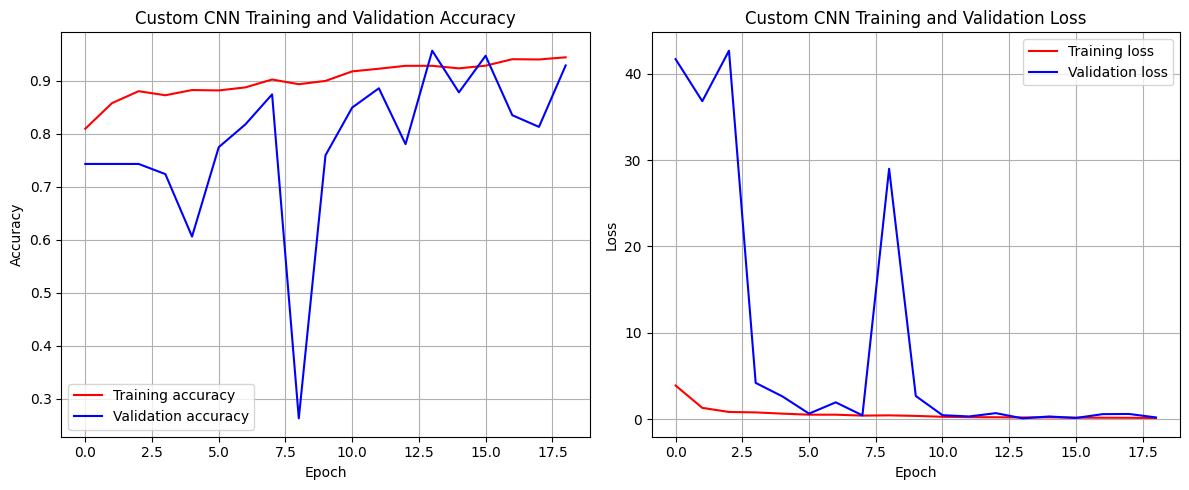

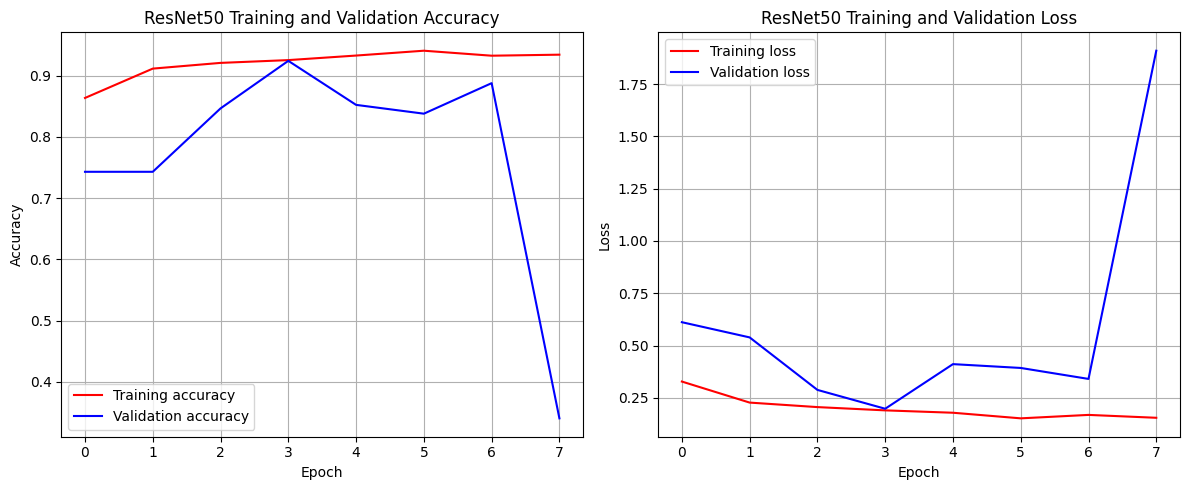

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step

--- ResNet50 Evaluation ---
              precision    recall  f1-score   support

      NORMAL       0.81      0.79      0.80       234
   PNEUMONIA       0.88      0.89      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624

----------------------------


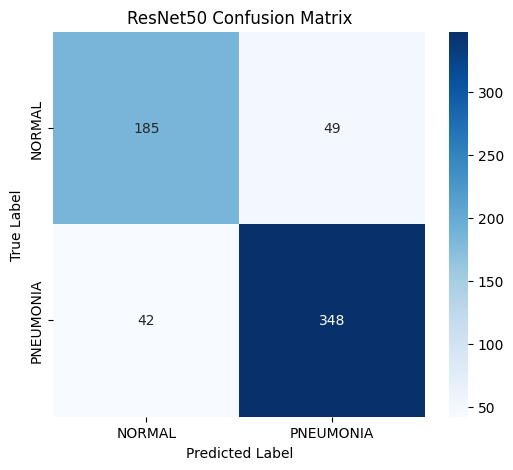


--- Interpretability XAI (Grad-CAM) ---
Using last convolutional layer: conv5_block3_3_conv for Grad-CAM

Generating Grad-CAM for 10 sample images...

Image 1 - True Class: NORMAL, Predicted Class: NORMAL


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_42']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-30-186274099>:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


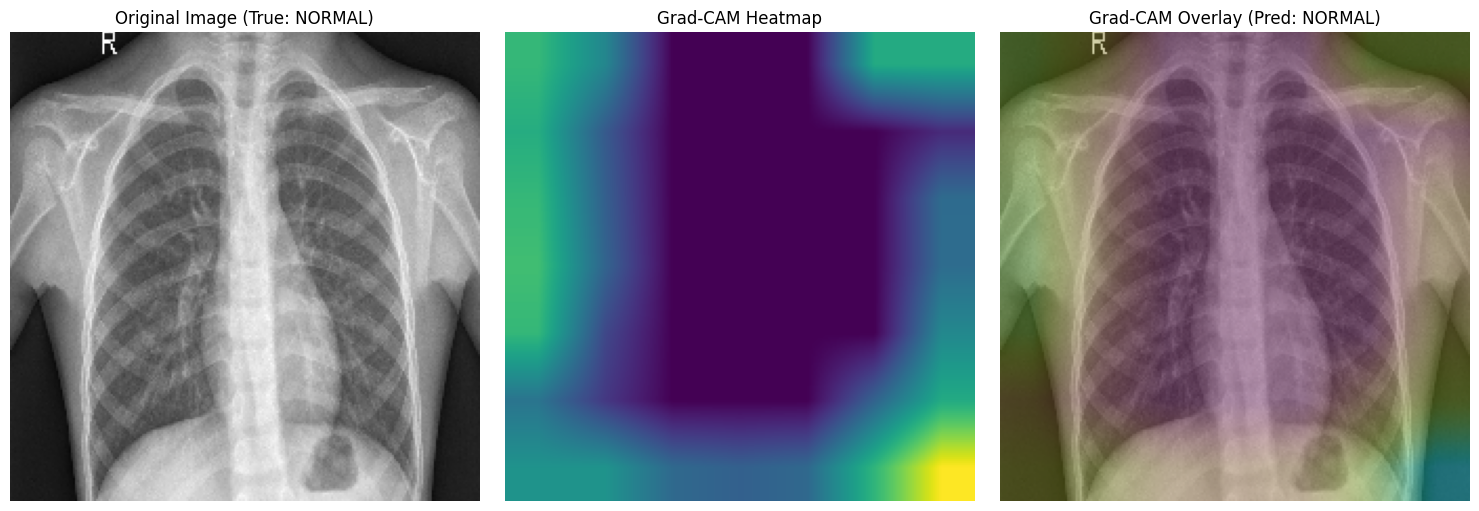


Image 2 - True Class: NORMAL, Predicted Class: NORMAL


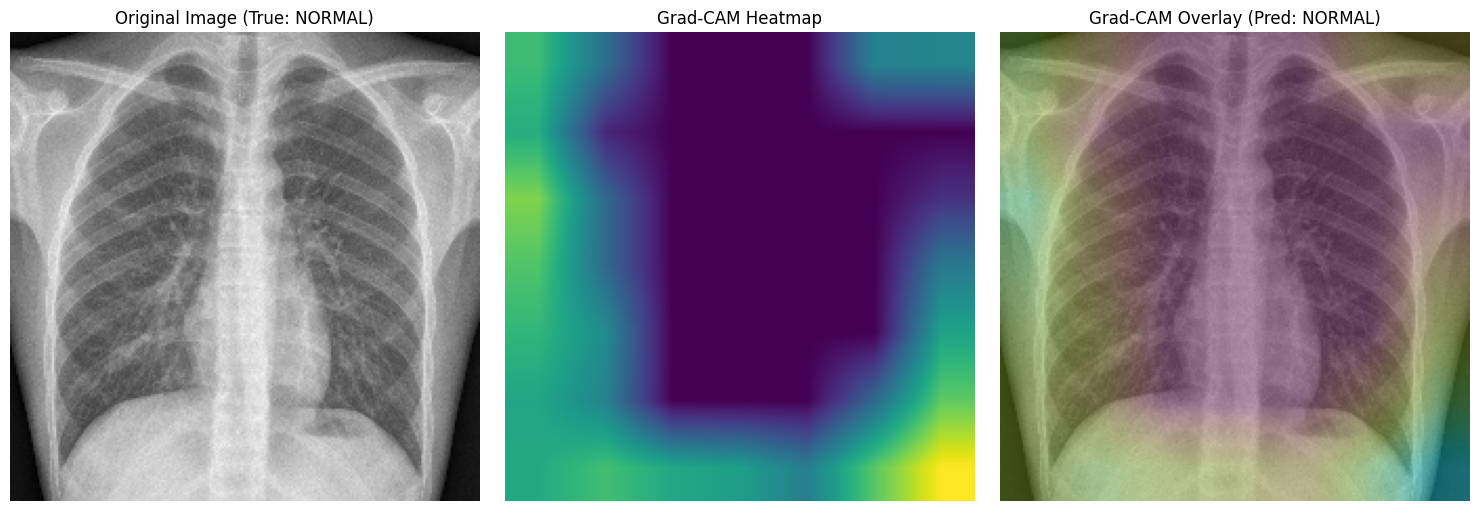


Image 3 - True Class: NORMAL, Predicted Class: NORMAL


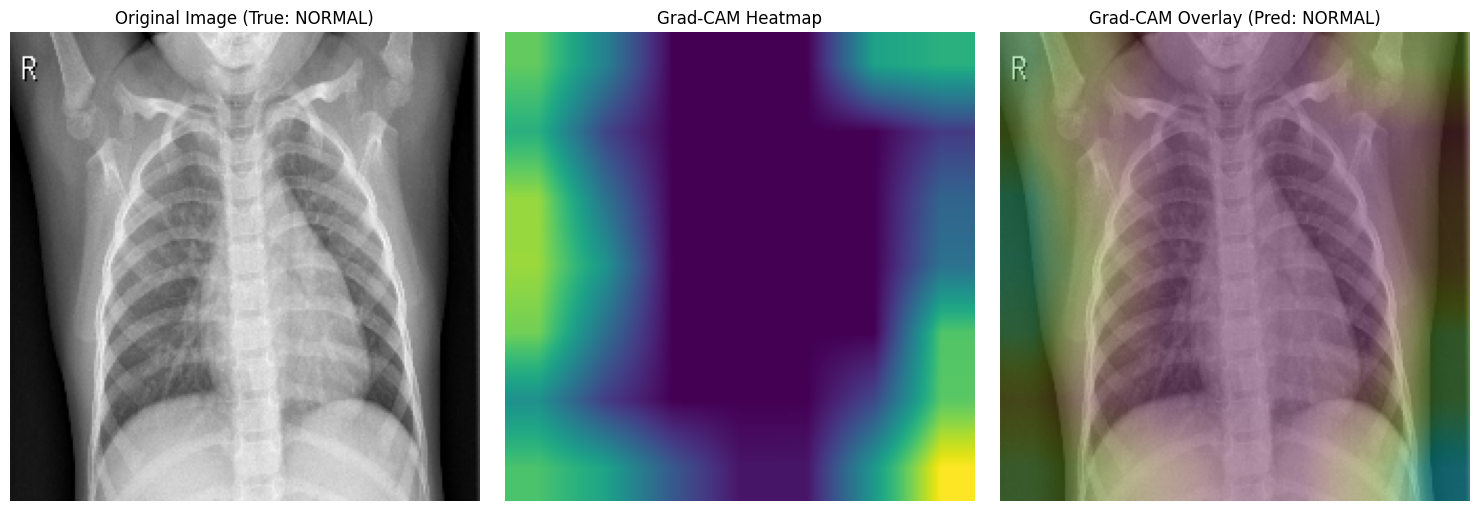


Image 4 - True Class: NORMAL, Predicted Class: NORMAL


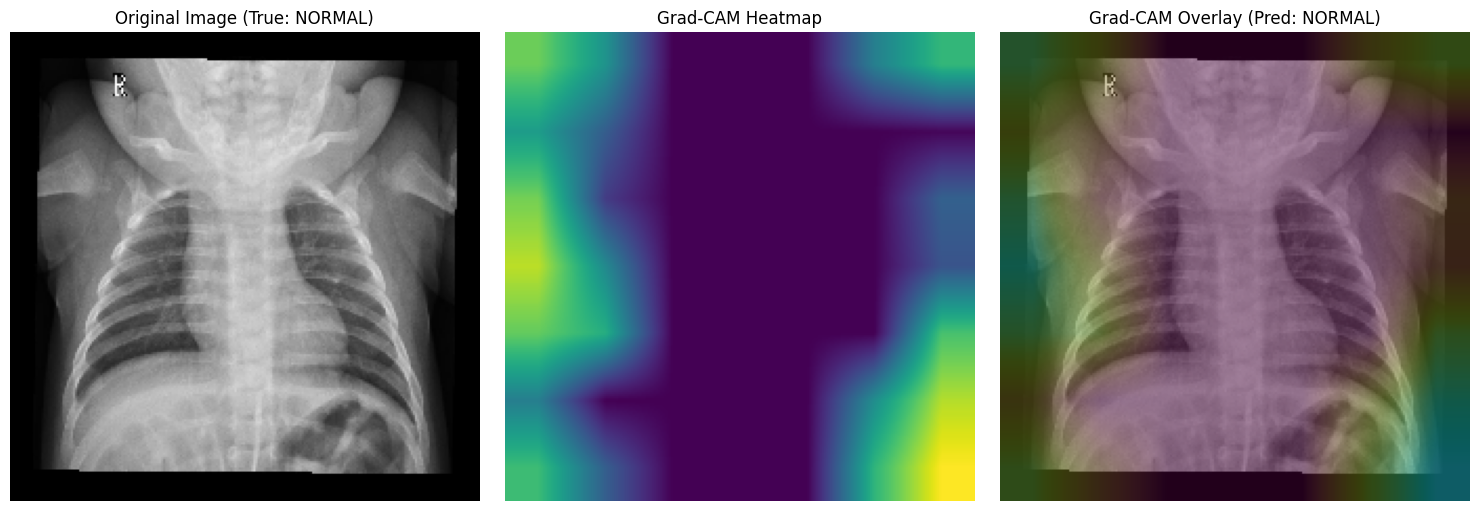


Image 5 - True Class: NORMAL, Predicted Class: PNEUMONIA


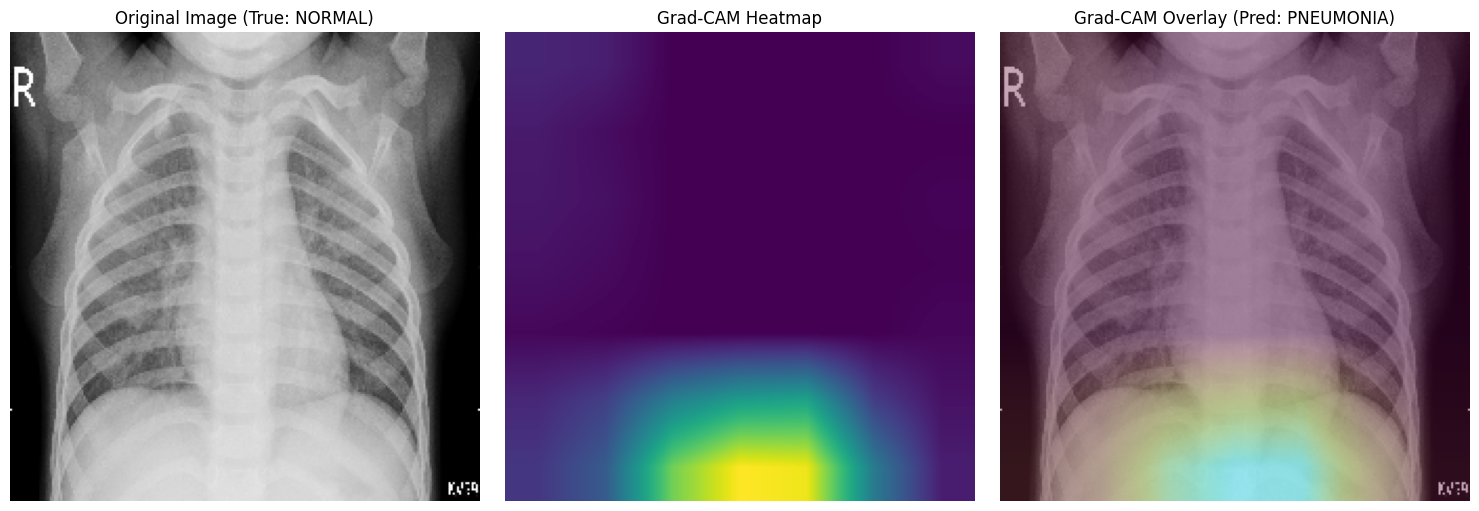


Image 6 - True Class: NORMAL, Predicted Class: NORMAL


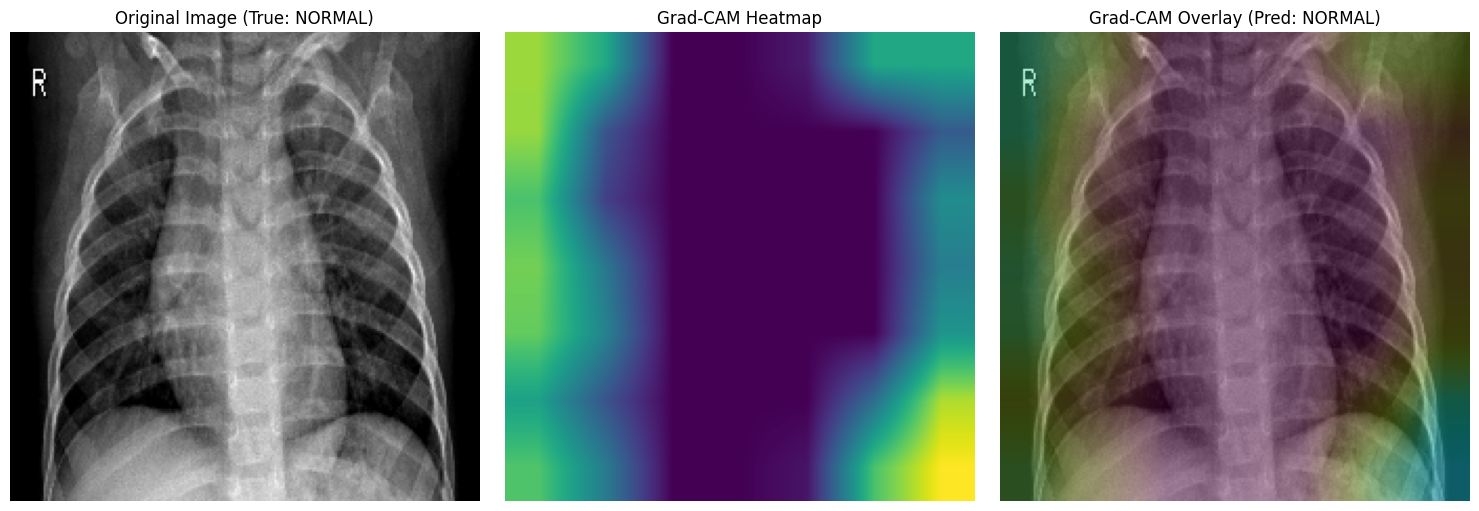


Image 7 - True Class: NORMAL, Predicted Class: NORMAL


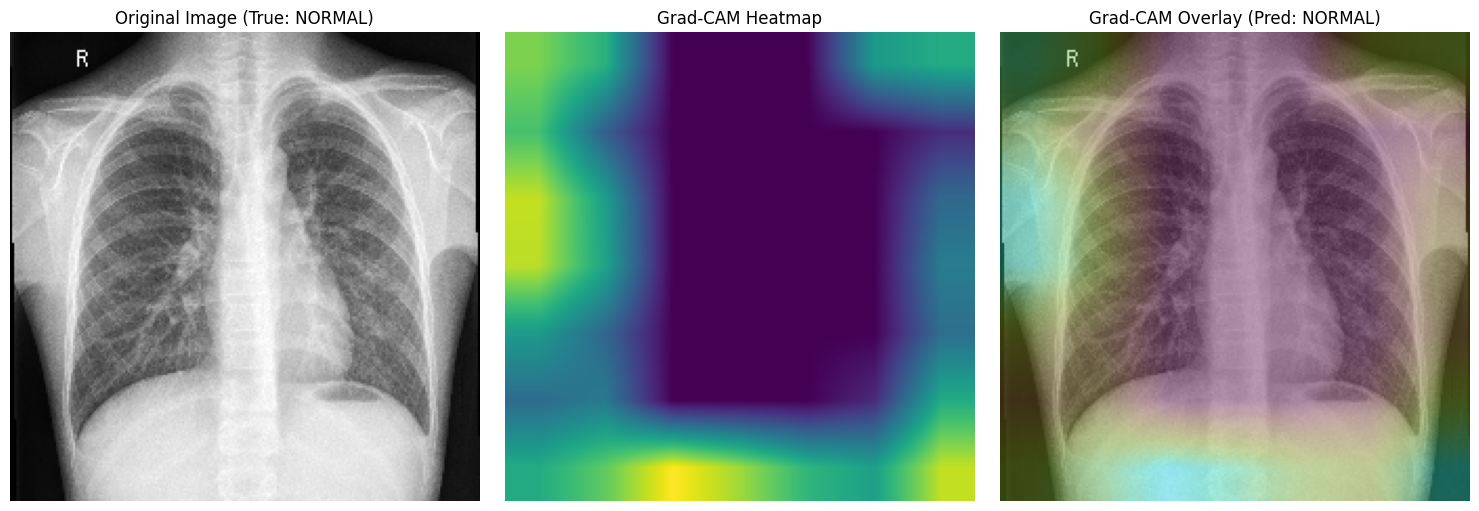


Image 8 - True Class: NORMAL, Predicted Class: NORMAL


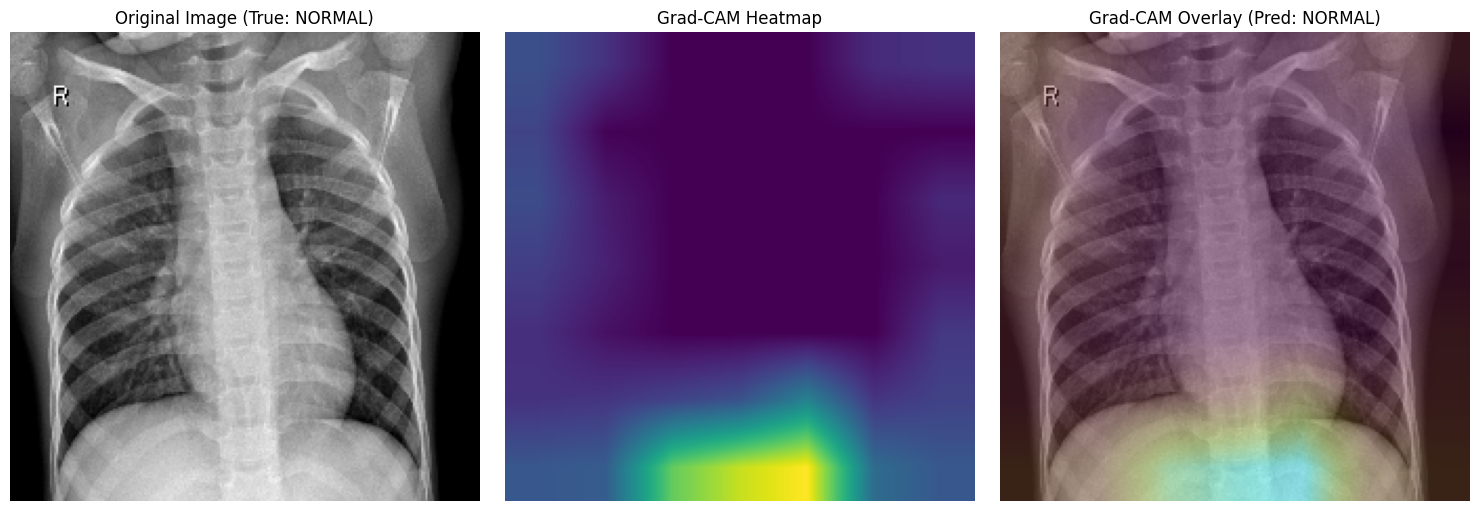


Image 9 - True Class: PNEUMONIA, Predicted Class: PNEUMONIA


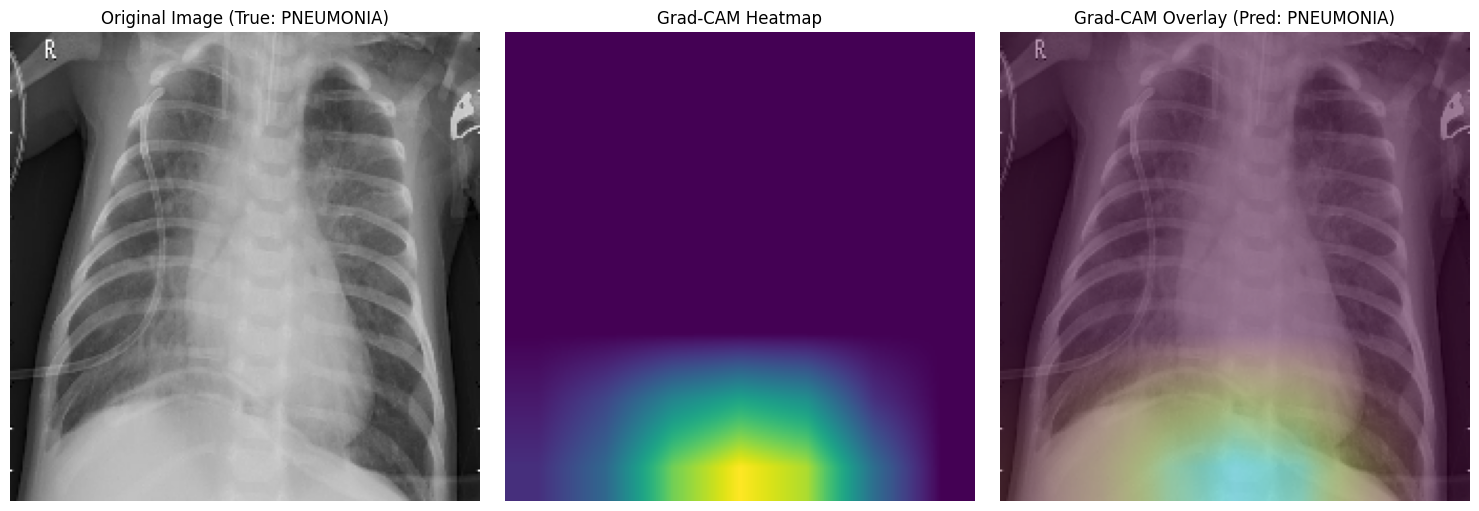


Image 10 - True Class: PNEUMONIA, Predicted Class: NORMAL


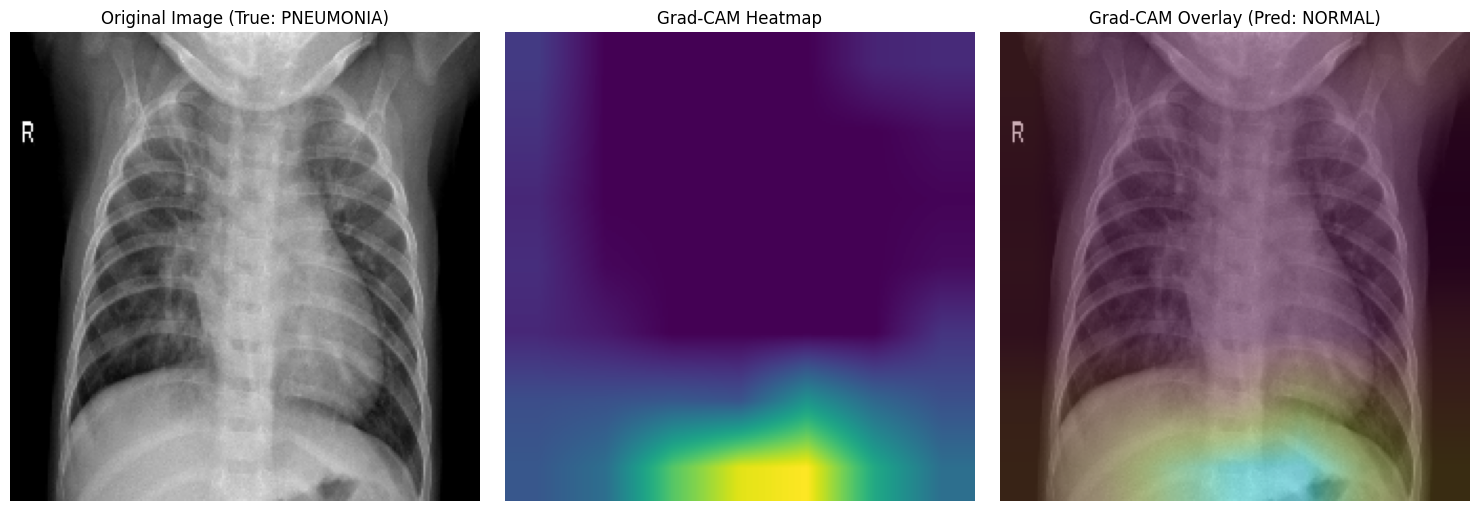

In [ ]:
# ------------------------------------------------------------------
# step 8: evaluation
# ------------------------------------------------------------------
import seaborn as sns

def plot_training_history(history, model_name): # plot training and validation curves
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.figure(figsize=(12, 5))

  # accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title(f'{model_name} Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # loss plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title(f'{model_name} Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

# plot history for both models
plot_training_history(history1, "Custom CNN")
plot_training_history(history2, "ResNet50")

def evaluate_model(model, name):
  test.reset()
  preds = model.predict(test, steps=test.samples // test.batch_size + (test.samples % test.batch_size > 0))
  preds_labels = (preds > 0.5).astype("int32").flatten()
  true_labels = test.classes[test.index_array]

  print(f"\n--- {name} Evaluation ---")
  print(classification_report(true_labels, preds_labels, target_names=["NORMAL", "PNEUMONIA"]))
  print("-" * (len(name) + 20))

  cm = confusion_matrix(true_labels, preds_labels)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
  plt.title(f'{name} Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

# evaluate both models
evaluate_model(resnet_model, "ResNet50")

# ------------------------------------------------------------------
# step 9: interpretability XAI (Grad-CAM)
# ------------------------------------------------------------------
print('\n--- Interpretability XAI (Grad-CAM) ---')

gradcam_model = resnet_model

def apply_gradcam(model, img_array, last_conv_layer_name, heatmap_size, original_img_display, pred_class, true_class):
  # create a model that outputs the activations of the last convolutional layer and the final prediction output
  grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

  # Compute the gradient of the top predicted class with respect to the output feature map of the last convolutional layer
  with tf.GradientTape() as tape:
    conv_layer_output, predictions = grad_model(img_array)
    tape.watch(conv_layer_output) # watch the output of the convolutional layer
    loss = predictions[:, 0] # gradient of the output probability (for sigmoid)

  grads = tape.gradient(loss, conv_layer_output) # get the gradients of the convolutional layer outputs with respect to the loss
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # global average pooling of the gradients to get weights
  conv_layer_output = conv_layer_output[0] # get the output feature maps of the last convolutional layer
  heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis] # multiply each channel in the feature map by the corresponding gradient weight
  heatmap = tf.squeeze(heatmap) # remove the last dimension of size 1
  heatmap = tf.maximum(heatmap, 0) # apply relu for normalisation
  max_heatmap = tf.reduce_max(heatmap)
  if max_heatmap == 0:
    print("Heatmap is all zeros, cannot normalize")
    return np.zeros_like(original_img_display), np.zeros(heatmap_size)
  else:
    heatmap /= max_heatmap # normalize to be between 0 and 1

  # resize the heatmap to the original image size
  heatmap_resized = tf.image.resize(
    tf.expand_dims(heatmap, axis=2), # add channel dimension
    heatmap_size # target size (original image size)
  )
  heatmap_resized = tf.squeeze(heatmap_resized.numpy()) # remove channel dimension and convert to numpy

  # convert the resized heatmap to a color map
  viridis = plt.cm.get_cmap('viridis')
  heatmap_colored = viridis(heatmap_resized)[:,:,:3] # get rgb, drop alpha
  heatmap_colored = (heatmap_colored * 255).astype(np.uint8)

  if original_img_display.shape[-1] == 1: # ensure original_img_display is RGB for consistent blending
    original_img_display = cv2.cvtColor(original_img_display, cv2.COLOR_GRAY2RGB) # superimpose the heatmap onto the original image

  superimposed_img = cv2.addWeighted(original_img_display, 0.6, heatmap_colored, 0.4, 0)

  return superimposed_img, heatmap_resized

last_conv_layer_name = None
for layer in reversed(gradcam_model.layers): # find the last convolutional layer in the selected model
  if isinstance(layer, Conv2D):
    last_conv_layer_name = layer.name
    break

if last_conv_layer_name is None:
  print("Could not find a Conv2D layer in the selected model for Grad-CAM.")
else:
  print(f"Using last convolutional layer: {last_conv_layer_name} for Grad-CAM")

  num_samples_to_visualize = 10
  print(f"\nGenerating Grad-CAM for {num_samples_to_visualize} sample images...")

  sample_images = []
  sample_labels = []
  num_collected = 0
  test.reset()
  for i in range(num_samples_to_visualize):
    try:
      batch_images, batch_labels = next(test) # get one batch
      sample_images.append(batch_images[0]) # take first image from the batch
      sample_labels.append(batch_labels[0])
      num_collected += 1
    except StopIteration:
        print(f"Collected only {num_collected} sample images before StopIteration.")
        break # stop if the generator is exhausted

  for i in range(num_collected): # process and display Grad-CAM for each collected sample
    sample_image = sample_images[i]
    sample_label = sample_labels[i]

    # prepare image for model input (flow_from_directory already rescales)
    sample_image_input = np.expand_dims(sample_image, axis=0) # add batch dimension

    predicted_prob = gradcam_model.predict(sample_image_input, verbose=0) # get the predicted class for the sample image
    predicted_class = 1 if predicted_prob > 0.5 else 0
    true_class = int(sample_label)

    print(f"\nImage {i+1} - True Class: {'PNEUMONIA' if true_class == 1 else 'NORMAL'}, Predicted Class: {'PNEUMONIA' if predicted_class == 1 else 'NORMAL'}")
    original_img_display = (sample_image * 255).astype(np.uint8)
    original_img_size = (original_img_display.shape[1], original_img_display.shape[0]) # (height, width) for heatmap resize

    # apply Grad-CAM
    superimposed_img, heatmap_data = apply_gradcam(gradcam_model, sample_image_input, last_conv_layer_name, original_img_size, original_img_display, predicted_class, true_class)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(sample_image)
    axes[0].set_title(f"Original Image (True: {'PNEUMONIA' if true_class else 'NORMAL'})")
    axes[0].axis('off')

    axes[1].imshow(heatmap_data, cmap='viridis')
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')

    # display superimposed image (using the 0-255 range version after cv2.addWeighted)
    axes[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)) # opencv uses bgr, matplotlib uses rgb
    axes[2].set_title(f"Grad-CAM Overlay (Pred: {'PNEUMONIA' if predicted_class else 'NORMAL'})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()